In [1]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [2]:
fmri_bounds = np.zeros((10,9))
reservoir_bounds = np.zeros((10,9))


In [3]:
# this is a loop on 10 subjects and reservoirs that does the HMM segmentation - it is to see the variability!!
ev11 = brainiak.eventseg.event.EventSegment(10)
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_tpj_data/matrix'+str(file_count+1)+'_notthefall_rev.npy')   
    ev11.fit(ntf_subject)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    fmri_bounds[file_count,:]=bounds11
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy')   
    ev11.fit(ntf_reservoir)
    bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]
    print(bounds11)
    reservoir_bounds[file_count,:]=bounds11

    
#fMRI bounds  [ 32  70 115 164 204 247 286 319 368] 400
#Reservoir bounds  [ 84 133 198 257 341 412 515 578 631] 682


   

[ 23  94 134 167 194 216 271 312 361]
[ 67 125 186 248 341 411 464 530 607]
[ 25  59 101 166 187 249 285 317 371]
[ 84 135 198 255 342 413 515 579 628]
[ 29  53  97 190 216 249 314 334 349]
[ 84 133 199 258 341 412 520 579 631]
[ 60  73 139 167 200 227 244 299 368]
[ 83 136 199 257 342 413 507 576 629]
[ 68  97 121 169 205 265 288 325 356]
[ 83 135 199 255 341 413 518 579 629]
[ 23  77  91 117 196 213 233 325 387]
[ 81 135 199 256 342 412 509 571 626]
[ 14  65 102 128 154 207 272 311 352]
[ 87 138 200 259 341 412 516 578 625]
[ 41  62  91 138 217 266 288 314 343]
[ 89 163 217 264 341 413 518 578 629]
[ 28  84 120 143 182 224 243 303 354]
[ 85 133 197 253 339 412 518 576 625]
[ 31  68 127 159 182 220 296 353 387]
[ 85 136 199 256 342 413 518 577 626]


In [4]:
# ok so now we make the final step and do the segmenation on the averages
for file_count in range(10):
    #fmri
    ntf_subject = np.load('ntf_tpj_data/matrix'+str(file_count+1)+'_notthefall_rev.npy')   
    if file_count == 0:
        fmri_averages = ntf_subject
    else:
        fmri_averages = fmri_averages + ntf_subject
    
    #reservoir
    ntf_reservoir = np.load('ntf_reservoir'+str(file_count+1)+'.npy') 
    if file_count == 0:
        reservoir_averages = ntf_reservoir
    else:
        reservoir_averages = reservoir_averages + ntf_reservoir

reservoir_averages = reservoir_averages/10
fmri_averages = fmri_averages/10

In [5]:
for j in range(fmri_averages.shape[1]):
    mean = fmri_averages[:,j].mean()
    if abs(mean) > 0.01:
        fmri_averages[:,j] = fmri_averages[:,j]/mean

In [6]:
for j in range(reservoir_averages.shape[1]):
    mean = reservoir_averages[:,j].mean()
    if abs(mean) > 0.0005:
        reservoir_averages[:,j] = reservoir_averages[:,j]/mean

In [7]:
ev_fmri = brainiak.eventseg.event.EventSegment(10)
ev_fmri.fit(fmri_averages)

ev_reservoir = brainiak.eventseg.event.EventSegment(10)
ev_reservoir.fit(reservoir_averages)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

fMRI bounds  [ 28  60 135 181 220 272 311 361 387]
Reservoir bounds  [ 84 134 199 259 341 414 517 579 628]


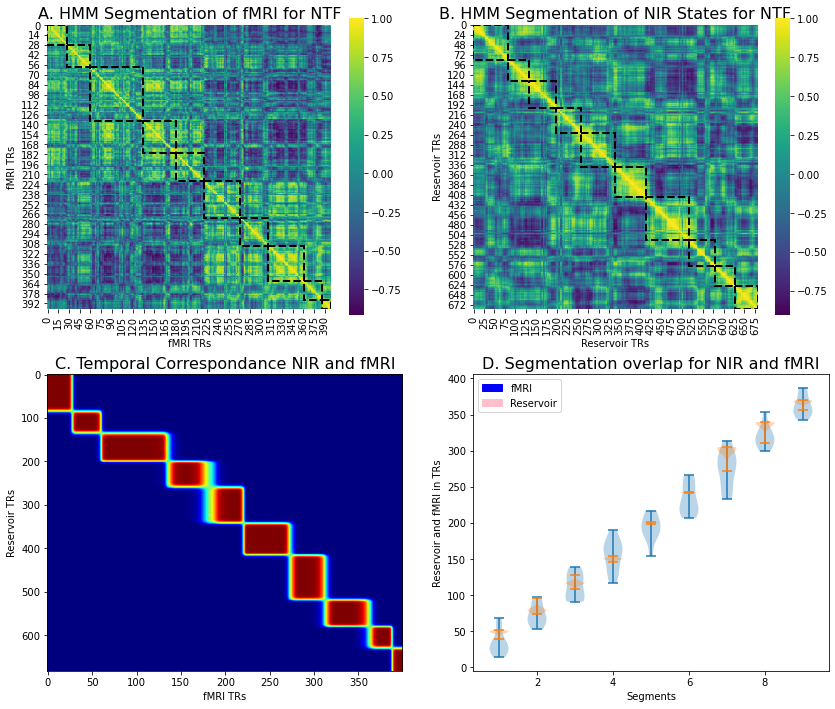

In [8]:
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
color='jet'
edge='black'
scale1=0.999
scale2=0.9
nTR=400

#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1, origin = 'lower')
#plt.imshow(np.corrcoef(fmri_averages), cmap=color, vmin = scale1)
#plt.imshow(np.corrcoef(fmri_averages))
sns.heatmap(np.corrcoef(fmri_averages),cmap='viridis', square=True)


bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('fMRI bounds ', bounds)
plt.xlabel('fMRI TRs')
plt.ylabel('fMRI TRs')

plt.title('A. HMM Segmentation of fMRI for NTF', fontsize = 16)


plt.subplot(2,2,2)

#plt.imshow(np.corrcoef(reservoir_averages),  vmin=scale2, cmap=color)
#plt.imshow(np.corrcoef(reservoir_averages))
sns.heatmap(np.corrcoef(reservoir_averages),cmap='viridis', square=True)

nTR=682
bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)

print('Reservoir bounds ', bounds)    
plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')

plt.title('B. HMM Segmentation of NIR States for NTF', fontsize = 16)


plt.subplot(2,2,3)

plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')

plt.title('C. Temporal Correspondance NIR and fMRI', fontsize = 16)



plt.subplot(2,2,4)

#plt.imshow(np.dot(ev_fmri.segments_[0], ev_reservoir.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',
plt.violinplot(fmri_bounds)
plt.violinplot(reservoir_bounds/682*400)

plt.xlabel('Segments')
plt.ylabel('Reservoir and fMRI in TRs')

red_patch = patches.Patch(color='pink', label='Reservoir')
#plt.legend(handles=[red_patch], loc='upper left')

blue_patch = patches.Patch(color='blue', label='fMRI')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

plt.title('D. Segmentation overlap for NIR and fMRI', fontsize = 16)




#fig.tight_layout()
plt.savefig('NTF-fmri-reservoir-revision.png', dpi=600)


In [10]:
segno=10
reps=10
fmri_bounds_means= np.zeros(segno-1)
reservoir_bounds_means= np.zeros(segno-1)


for i in range(segno-1):
    fmri_bounds_means[i] = fmri_bounds[:reps,i].mean()
    reservoir_bounds_means[i] =reservoir_bounds[:reps,i].mean()

p = 0.8660860564648121


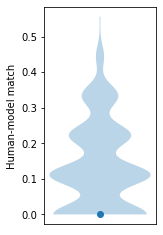

In [17]:
bounds = np.where(np.diff(np.argmax(ev_fmri.segments_[0], axis=1)))[0]

h_bounds = np.where(np.diff(np.argmax(ev_reservoir.segments_[0], axis=1)))[0]
h_bounds = h_bounds/682*400

bounds = fmri_bounds_means
h_bounds = reservoir_bounds_means/682*400



np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in h_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(h_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

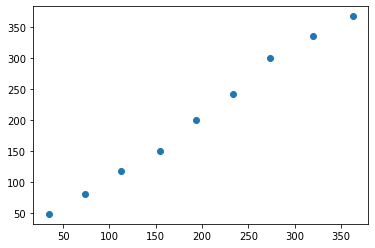

In [18]:
plt.scatter(bounds, h_bounds)

In [ ]:
#fmri_bounds
#reservoir_bounds/682*400
i=0
for i in range(10):
    correlation, p_value = stats.pearsonr(fmri_bounds[i], reservoir_bounds[i])
    print('correltion: ',correlation)
    print('p_value: ', p_value)
